### Libraries

In [31]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import itertools
import random
import kagglehub
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import seaborn as sns

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing import image

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

sns.set_style('darkgrid')

In [3]:
def seed_everything(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ["TF_DETERMINISTIC_OPS"] = "1"

    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

    # TF >= 2.9 (best effort)
    try:
        tf.keras.utils.set_random_seed(seed)
        tf.config.experimental.enable_op_determinism()
    except Exception:
        pass

seed_everything(42)

### Helper functions

In [4]:
import urllib.request

url = "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py"
urllib.request.urlretrieve(url, "helper_functions.py")

# now import
from helper_functions import (
    create_tensorboard_callback, plot_loss_curves, unzip_data,
    compare_historys, walk_through_dir, pred_and_plot
)
print("helper_functions.py downloaded and imported")


helper_functions.py downloaded and imported


### Load and Transform Data

In [5]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

In [6]:
dataset_path = Path(kagglehub.dataset_download("jxwleong/coral-reef-dataset"))
csv_path = dataset_path / "combined_annotations_remapped.csv"

# Try common encodings
for enc in ["utf-8", "utf-8-sig", "cp1252", "latin1"]:
    try:
        df = pd.read_csv(csv_path, encoding=enc)
        print("✅ Loaded with encoding:", enc)
        break
    except UnicodeDecodeError:
        pass

df.head()


✅ Loaded with encoding: utf-8


Name  Row  Column                Label  Unnamed: 4
0  i0201a.png  111      94  broken_coral_rubble         NaN
1  i0201a.png  173     243  broken_coral_rubble         NaN
2  i0201a.png   84     366  broken_coral_rubble         NaN
3  i0201a.png   54     802  broken_coral_rubble         NaN
4  i0201a.png  313      66                 sand         NaN

In [7]:
print(df.columns)
print(df.head())
print(df["Label"].nunique())


Index(['Name', 'Row', 'Column', 'Label', 'Unnamed: 4'], dtype='object')
         Name  Row  Column                Label  Unnamed: 4
0  i0201a.png  111      94  broken_coral_rubble         NaN
1  i0201a.png  173     243  broken_coral_rubble         NaN
2  i0201a.png   84     366  broken_coral_rubble         NaN
3  i0201a.png   54     802  broken_coral_rubble         NaN
4  i0201a.png  313      66                 sand         NaN
40


Clean the CSV (drop junk + normalize labels)

In [8]:
# df is already loaded
df = df.drop(columns=["Unnamed: 4"], errors="ignore")

# normalize label text (keep underscores)
df["Label"] = df["Label"].astype(str).str.strip().str.lower()

print("Unique labels:", df["Label"].nunique())
print(df["Label"].value_counts().head(15))

Unique labels: 40
Label
crustose_coralline_algae    226017
turf                         43769
sand                         38880
porites                      35236
macroalgae                   23832
off                          13605
pocillopora                  11319
montipora                     8755
pavona                        5806
acropora                      3458
hard_substrate                2086
millepora                     1459
broken_coral_rubble           1025
montastraea                    645
leptastrea                     528
Name: count, dtype: int64


Remove “bad/invalid” labels

In [9]:
bad_labels = {"bad", "dark", "off", "unknown", "unlabeled", "background", "water"}
df = df[~df["Label"].isin(bad_labels)]

print("After removing invalid labels:")
print("Unique labels:", df["Label"].nunique())


After removing invalid labels:
Unique labels: 37


Choose Top-N classes

In [10]:
keep_labels = ["crustose_coralline_algae", "sand", "porites"]  # choose your own
df_top = df[df["Label"].isin(keep_labels)].copy()



Convert point-annotations → image-level label
This creates one label per image, which is what VGG19 needs.

In [11]:
image_labels = (
    df_top.groupby("Name")["Label"]
          .agg(lambda s: s.value_counts().idxmax())
          .reset_index()
          .rename(columns={"Name": "filename", "Label": "label"})
)

print("Image-level samples:")
print(image_labels.head())
print("Image-level class counts:")
print(image_labels["label"].value_counts())


Image-level samples:
     filename label
0  i0201a.png  sand
1  i0201d.png  sand
2  i0202b.png  sand
3  i0202d.png  sand
4  i0203a.png  sand
Image-level class counts:
label
crustose_coralline_algae    1647
sand                         338
porites                      237
Name: count, dtype: int64


Remove “uncertain” images

If an image has mixed labels, majority vote might be weak.
Keep only images where the majority class is strong (e.g., ≥60%).

In [12]:
def majority_ratio(s):
    return s.value_counts(normalize=True).iloc[0]

ratios = df_top.groupby("Name")["Label"].apply(majority_ratio).reset_index(name="majority_ratio")

image_labels = image_labels.merge(ratios, left_on="filename", right_on="Name", how="left").drop(columns=["Name"])

THRESH = 0.5
image_labels_clean = image_labels[image_labels["majority_ratio"] >= THRESH].drop(columns=["majority_ratio"])

print("Before filter:", len(image_labels), "After filter:", len(image_labels_clean))
print(image_labels_clean["label"].value_counts())


Before filter: 2222 After filter: 2177
label
crustose_coralline_algae    1634
sand                         327
porites                      216
Name: count, dtype: int64


In [13]:
print(dataset_path)


C:\Users\user\.cache\kagglehub\datasets\jxwleong\coral-reef-dataset\versions\2


Create “filepath + label” by matching filenames to real images

In [14]:
dataset_path = Path(r"C:\Users\user\.cache\kagglehub\datasets\jxwleong\coral-reef-dataset\versions\2")

# Find all images
all_imgs = []
for ext in ("*.png", "*.jpg", "*.jpeg", "*.PNG", "*.JPG", "*.JPEG"):
    all_imgs += list(dataset_path.rglob(ext))

print("Total images found:", len(all_imgs))

# Map filename -> full path
img_map = {p.name: str(p) for p in all_imgs}

# Add full paths to your cleaned labels
final_df = image_labels_clean.copy()
final_df["filepath"] = final_df["filename"].map(img_map)

# Keep only matched files
final_df = final_df.dropna(subset=["filepath"]).reset_index(drop=True)

print("Matched labeled images:", len(final_df))
print(final_df.head())
print(final_df["label"].value_counts())


Total images found: 9010
Matched labeled images: 2177
     filename label                                           filepath
0  i0201a.png  sand  C:\Users\user\.cache\kagglehub\datasets\jxwleo...
1  i0201d.png  sand  C:\Users\user\.cache\kagglehub\datasets\jxwleo...
2  i0202b.png  sand  C:\Users\user\.cache\kagglehub\datasets\jxwleo...
3  i0202d.png  sand  C:\Users\user\.cache\kagglehub\datasets\jxwleo...
4  i0203a.png  sand  C:\Users\user\.cache\kagglehub\datasets\jxwleo...
label
crustose_coralline_algae    1634
sand                         327
porites                      216
Name: count, dtype: int64


### Data Preprocessing

In [15]:
train_df, temp_df = train_test_split(
    final_df, test_size=0.2, random_state=42, stratify=final_df["label"]
)

val_df, test_df = train_test_split(
    temp_df, test_size=0.5, random_state=42, stratify=temp_df["label"]
)

print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))
print(train_df["label"].value_counts())


Train: 1741 Val: 218 Test: 218
label
crustose_coralline_algae    1307
sand                         261
porites                      173
Name: count, dtype: int64


In [16]:
print("Train:", train_df["label"].value_counts())
print("Val:", val_df["label"].value_counts())
print("Test:", test_df["label"].value_counts())


Train: label
crustose_coralline_algae    1307
sand                         261
porites                      173
Name: count, dtype: int64
Val: label
crustose_coralline_algae    163
sand                         33
porites                      22
Name: count, dtype: int64
Test: label
crustose_coralline_algae    164
sand                         33
porites                      21
Name: count, dtype: int64


Data generators

In [17]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_datagen = ImageDataGenerator(rescale=1./255)

# ✅ AFTER train/val/test split
max_n = train_df["label"].value_counts().max()

train_balanced = (
    train_df.groupby("label", group_keys=False)
            .apply(lambda x: x.sample(max_n, replace=True, random_state=42))
            .sample(frac=1, random_state=42)
            .reset_index(drop=True)
)

print("Before balancing:\n", train_df["label"].value_counts())
print("After balancing:\n", train_balanced["label"].value_counts())

# ✅ THEN build generators (train uses train_balanced)
train_gen = train_datagen.flow_from_dataframe(
    train_balanced,
    x_col="filepath",
    y_col="label",
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

val_gen = test_datagen.flow_from_dataframe(
    val_df,
    x_col="filepath",
    y_col="label",
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_gen = test_datagen.flow_from_dataframe(
    test_df,
    x_col="filepath",
    y_col="label",
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


val_gen = test_datagen.flow_from_dataframe(
    val_df,
    x_col="filepath",
    y_col="label",
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_gen = test_datagen.flow_from_dataframe(
    test_df,
    x_col="filepath",
    y_col="label",
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

print("Class indices:", train_gen.class_indices)
num_classes = len(train_gen.class_indices)


Before balancing:
 label
crustose_coralline_algae    1307
sand                         261
porites                      173
Name: count, dtype: int64
After balancing:
 label
crustose_coralline_algae    1307
sand                        1307
porites                     1307
Name: count, dtype: int64
Found 3921 validated image filenames belonging to 3 classes.
Found 218 validated image filenames belonging to 3 classes.
Found 218 validated image filenames belonging to 3 classes.
Found 218 validated image filenames belonging to 3 classes.
Found 218 validated image filenames belonging to 3 classes.
Class indices: {'crustose_coralline_algae': 0, 'porites': 1, 'sand': 2}


C:\Users\user\AppData\Local\Temp\ipykernel_23392\3788154164.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(max_n, replace=True, random_state=42))


In [18]:
classes = np.array(sorted(train_df["label"].unique()))

weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=train_df["label"].values
)

class_weight_dict = dict(zip(classes, weights))
print(class_weight_dict)

{np.str_('crustose_coralline_algae'): np.float64(0.4440193828105075), np.str_('porites'): np.float64(3.3545279383429674), np.str_('sand'): np.float64(2.2234993614303957)}


### VGG19 transfer learning model

In [19]:
base_model = VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)
base_model.trainable = False  # freeze for first stage

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation="softmax")  # ✅ 4 classes
])

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,158,531 (76.90 MB)

 Trainable params: 133,123 (520.01 KB)

 Non-trainable params: 20,025,408 (76.39 MB)

### Train with class weights + callbacks

In [20]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=2, min_lr=1e-6),
    ModelCheckpoint("vgg19_best.keras", monitor="val_loss", save_best_only=True),
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    callbacks=callbacks,
    class_weight=class_weight_dict  # ✅ your imbalance fix
)

Epoch 1/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 321s 3s/step - accuracy: 0.5886 - loss: 0.9109 - val_accuracy: 0.5917 - val_loss: 0.8751 - learning_rate: 1.0000e-04
Epoch 2/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 305s 2s/step - accuracy: 0.7363 - loss: 0.6303 - val_accuracy: 0.7615 - val_loss: 0.6549 - learning_rate: 1.0000e-04
Epoch 3/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 279s 2s/step - accuracy: 0.7682 - loss: 0.5673 - val_accuracy: 0.8165 - val_loss: 0.5091 - learning_rate: 1.0000e-04
Epoch 4/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 235s 2s/step - accuracy: 0.7888 - loss: 0.5197 - val_accuracy: 0.8486 - val_loss: 0.4603 - learning_rate: 1.0000e-04
Epoch 5/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 235s 2s/step - accuracy: 0.7978 - loss: 0.5018 - val_accuracy: 0.8486 - val_loss: 0.4490 - learning_rate: 1.0000e-04


### Confusion matrix 

In [21]:
# Predict
pred_probs = model.predict(test_gen)
y_pred = np.argmax(pred_probs, axis=1)
y_true = test_gen.classes

# Class names in correct order
class_names = list(test_gen.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step
                          precision    recall  f1-score   support

crustose_coralline_algae       0.98      0.84      0.90       164
                 porites       0.30      0.67      0.42        21
                    sand       0.69      0.67      0.68        33

                accuracy                           0.79       218
               macro avg       0.66      0.72      0.67       218
            weighted avg       0.87      0.79      0.82       218

Confusion Matrix:
 [[137  23   4]
 [  1  14   6]
 [  2   9  22]]


### Finetuned train

In [22]:
base_model.trainable = True

# unfreeze only last ~5 layers (you can try -8 too)
for layer in base_model.layers[:-5]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_ft = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    callbacks=callbacks,
    class_weight=class_weight_dict
)

Epoch 1/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 259s 2s/step - accuracy: 0.8355 - loss: 0.4223 - val_accuracy: 0.8716 - val_loss: 0.3362 - learning_rate: 1.0000e-05
Epoch 2/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step - accuracy: 0.8732 - loss: 0.3168 - val_accuracy: 0.9128 - val_loss: 0.2821 - learning_rate: 1.0000e-05
Epoch 3/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step - accuracy: 0.8967 - loss: 0.2550 - val_accuracy: 0.9083 - val_loss: 0.2488 - learning_rate: 1.0000e-05
Epoch 4/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step - accuracy: 0.9130 - loss: 0.2250 - val_accuracy: 0.9174 - val_loss: 0.2275 - learning_rate: 1.0000e-05
Epoch 5/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 256s 2s/step - accuracy: 0.9327 - loss: 0.1830 - val_accuracy: 0.9037 - val_loss: 0.2307 - learning_rate: 1.0000e-05


### Confusion matrix 

In [23]:
# Predict
pred_probs = model.predict(test_gen)
y_pred = np.argmax(pred_probs, axis=1)
y_true = test_gen.classes

# Class names in correct order
class_names = list(test_gen.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step
                          precision    recall  f1-score   support

crustose_coralline_algae       0.99      0.91      0.95       164
                 porites       0.57      0.76      0.65        21
                    sand       0.79      0.94      0.86        33

                accuracy                           0.90       218
               macro avg       0.79      0.87      0.82       218
            weighted avg       0.92      0.90      0.91       218

Confusion Matrix:
 [[150  10   4]
 [  1  16   4]
 [  0   2  31]]


### Visualization

train  val  test
label                                     
crustose_coralline_algae   1307  163   164
sand                        261   33    33
porites                     173   22    21

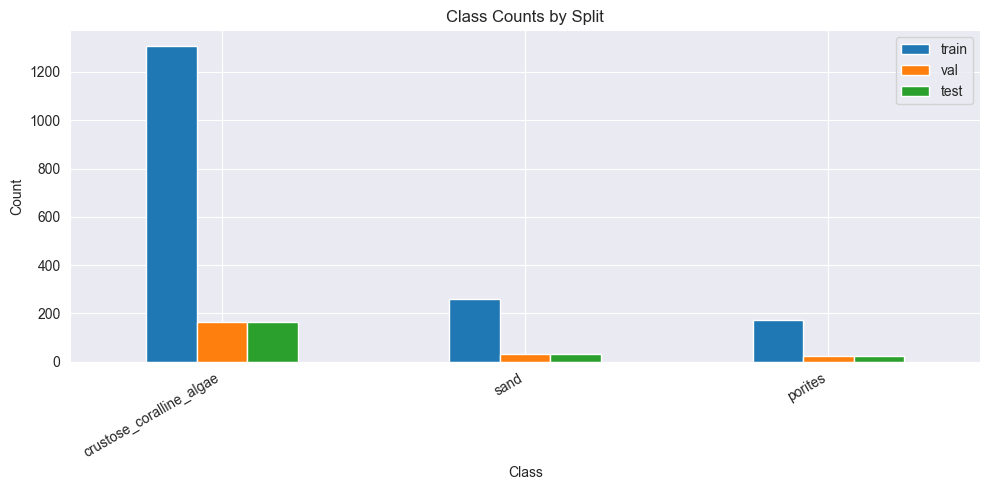

In [24]:
def plot_split_distribution(train_df, val_df, test_df):
    a = train_df["label"].value_counts().rename("train")
    b = val_df["label"].value_counts().rename("val")
    c = test_df["label"].value_counts().rename("test")
    dist = pd.concat([a,b,c], axis=1).fillna(0).astype(int)
    display(dist)

    dist.plot(kind="bar", figsize=(10,5))
    plt.title("Class Counts by Split")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()

plot_split_distribution(train_df, val_df, test_df)

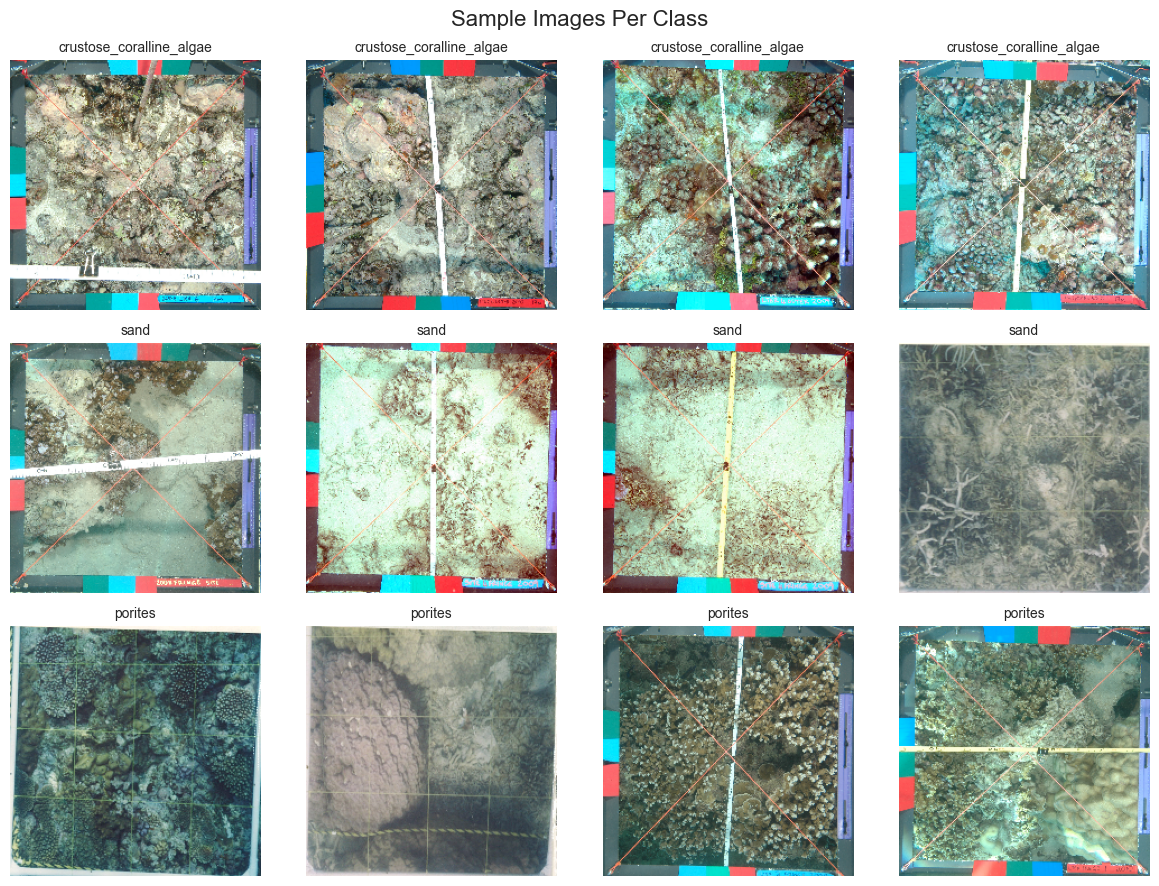

In [25]:
def show_samples(df, n_per_class=4, target_size=(224,224)):
    classes = df["label"].unique().tolist()
    plt.figure(figsize=(n_per_class*3, len(classes)*3))

    plot_i = 1
    for cls in classes:
        sample_paths = df[df["label"] == cls]["filepath"].sample(
            min(n_per_class, (df["label"]==cls).sum()), random_state=42
        ).tolist()

        for p in sample_paths:
            img = cv2.imread(p)  # BGR
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, target_size)

            ax = plt.subplot(len(classes), n_per_class, plot_i)
            ax.imshow(img)
            ax.set_title(cls, fontsize=10)
            ax.axis("off")
            plot_i += 1

    plt.suptitle("Sample Images Per Class", fontsize=16)
    plt.tight_layout()
    plt.show()

show_samples(train_df, n_per_class=4)

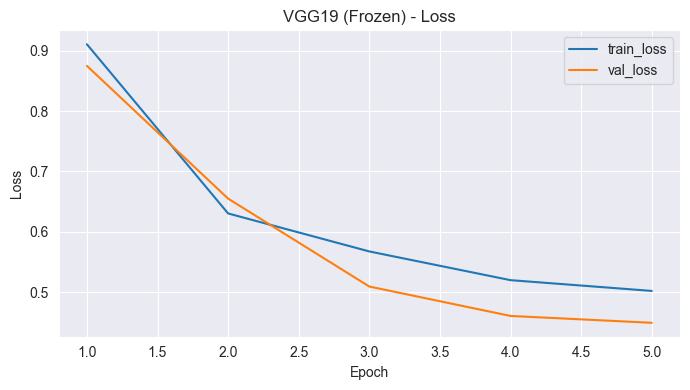

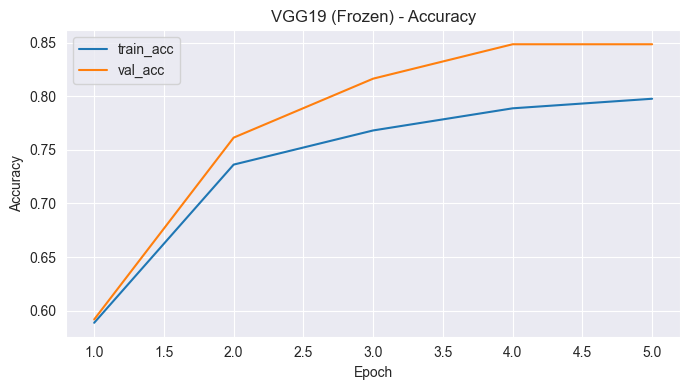

In [26]:
def plot_history(hist, title="Training Curves"):
    h = hist.history
    epochs = range(1, len(h["loss"]) + 1)

    plt.figure(figsize=(7,4))
    plt.plot(epochs, h["loss"], label="train_loss")
    plt.plot(epochs, h["val_loss"], label="val_loss")
    plt.title(f"{title} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

    if "accuracy" in h:
        plt.figure(figsize=(7,4))
        plt.plot(epochs, h["accuracy"], label="train_acc")
        plt.plot(epochs, h["val_accuracy"], label="val_acc")
        plt.title(f"{title} - Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.tight_layout()
        plt.show()

plot_history(history, title="VGG19 (Frozen)")
# plot_history(history_ft, title="VGG19 (Fine-tuned)")  # if you did fine-tuning

7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step


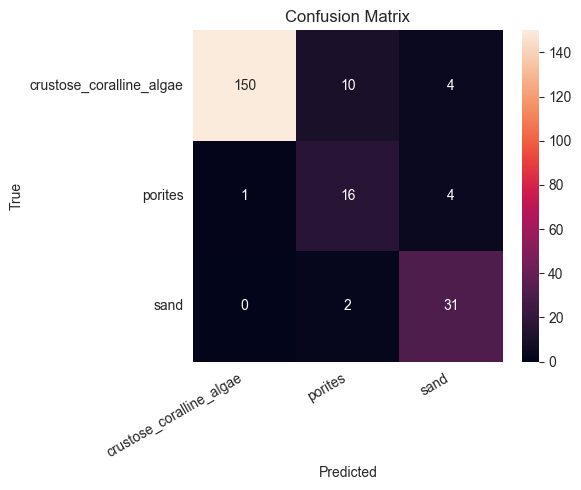

In [27]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(rotation=30, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# after prediction
pred_probs = model.predict(test_gen)
y_pred = np.argmax(pred_probs, axis=1)
y_true = test_gen.classes
class_names = list(test_gen.class_indices.keys())

plot_confusion_matrix(y_true, y_pred, class_names)

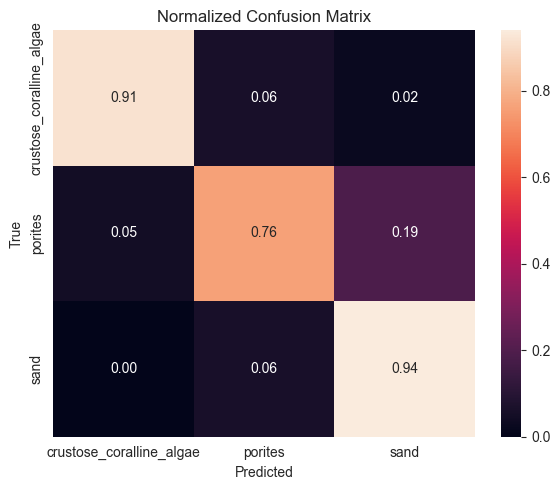

In [28]:
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=True, fmt=".2f",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

In [29]:
model.save("coral_vgg19.keras")


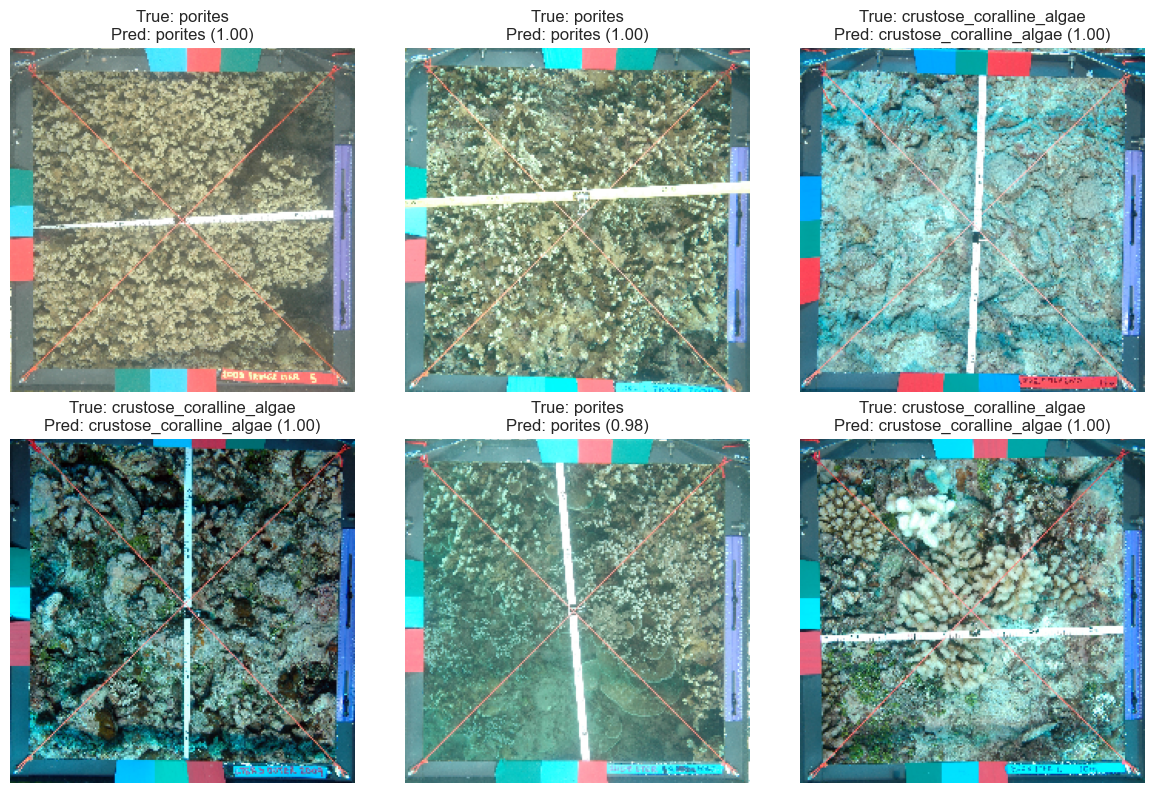

In [32]:
def predict_and_show(model, df, n=6, target_size=(224,224)):
    sample = df.sample(n, random_state=42).reset_index(drop=True)

    plt.figure(figsize=(12, 8))
    for i in range(n):
        img_path = sample.loc[i, "filepath"]
        true_label = sample.loc[i, "label"]

        img = image.load_img(img_path, target_size=target_size)
        x = image.img_to_array(img) / 255.0
        x = np.expand_dims(x, axis=0)

        probs = model.predict(x, verbose=0)[0]
        pred_idx = np.argmax(probs)
        pred_label = class_names[pred_idx]
        conf = probs[pred_idx]

        ax = plt.subplot(2, (n+1)//2, i+1)
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(f"True: {true_label}\nPred: {pred_label} ({conf:.2f})")

    plt.tight_layout()
    plt.show()

# class_names must match your generator order:
# class_names = list(test_gen.class_indices.keys())
predict_and_show(model, test_df, n=6)